# TWITTER SENTIMENTAL ANALYSIS MODEL

## Importing Libraries

In [38]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import nltk

## Loading the dataset

In [39]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv")
df.columns=['target','ids','date','flag','user','text']
df.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew



## Exploratory Data Analysis

In [40]:
#Length of the dataset
len(df)

1599999

In [41]:
#shape of the data
df.shape

(1599999, 6)

In [42]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [43]:
#Datatypes of all columns
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [44]:
#Checking for Null values
np.sum(df.isnull().any(axis=1))

0

In [45]:
#No of columns
print(len(df.columns))
#No of row
print(len(df))

6
1599999


In [46]:
#Check unique Target Values
df['target'].unique()

array([0, 4], dtype=int64)

In [47]:
#Check the number of target values
df['target'].nunique()

2

## Data Visualization of Target Variables

<AxesSubplot:xlabel='target', ylabel='count'>

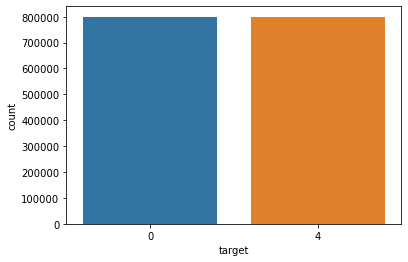

In [48]:

sns.countplot(x='target', data=df)

## Data Preprocessing

In [49]:
#Selecting the text and Target column for our further analysis
data=df[['text','target']]

In [50]:
#Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data['target'] = data['target'].replace(4,1)

<ipython-input-50-18d0e05f61d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [51]:
#Print unique values of target variables
data['target'].unique()

array([0, 1], dtype=int64)

In [52]:
#Separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [53]:
#taking one fourth data so we can run on our machine easily
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [54]:
#Combining positive and negative tweets
dataset = pd.concat([data_pos, data_neg])

In [55]:
#Making statement text in lower case
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

In [56]:
#Defining set containing all stopwords in English.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [57]:
#Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [58]:
#Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998    threw sign donnie bent over get but thingee ma...
19999    heather2711 good thing didnt find none ones li...
Name: text, dtype: object

In [59]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998    threw sign donnie bent over get but thingee ma...
19999    heather21 good thing didnt find none ones like...
Name: text, dtype: object

In [60]:
#Cleaning and removing URL’s
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998    threw sign donnie bent over get but thingee ma...
19999    heather21 good thing didnt find none ones like...
Name: text, dtype: object

In [61]:
# Cleaning and removing Numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998    threw sign donnie bent over get but thingee ma...
19999    heather good thing didnt find none ones like c...
Name: text, dtype: object

In [62]:
#Getting tokenization of tweet text



In [63]:
from nltk.tokenize import word_tokenize
dataset['text'] = dataset['text'].apply(word_tokenize)
dataset['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [64]:
#Applying Stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [65]:
#Applying Lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [darealsunisakim, thanks, twitter, add, sunisa...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [66]:
#Separating input feature and label
X=data.text
y=data.target

In [67]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [68]:
#Fit the TF-IDF Vectorizer
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)



TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [69]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

## MODEL BUILDING

In [70]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred3 = LRmodel.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000

